In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

### Loading and preprocessing

In [2]:
df = pd.read_csv('../data/owd.csv')

In [3]:
df['data'] = df['data'].apply(lambda x: eval(x))
df = df.explode('data')
df.reset_index(drop=True, inplace=True)

In [4]:
df = pd.concat((df, df['data'].apply(pd.Series)), axis=1)
df['dt'] = pd.to_datetime(df['dt'], unit='s')

Removing the dates because each event has accurrate datetime info

In [5]:
df.drop(columns=['Unnamed: 0', 'data', 'createdAt', 'date', 'updatedAt',
                 *[c for c in df.columns if c == 'id' or '_id' in c]], inplace=True)

In [6]:
df['weather'] = df['weather'].apply(lambda x: x[0])

Unpacking all the data from dictionaries within events

In [7]:
dict_col_dfs = []
dict_cols = []

for c in df.columns:
    if type(df[df[c].notnull()].iloc[0][c]) is dict:
        print(c)
        cur = df[c].apply(pd.Series)
        cur.columns = [c + '_' + str(x) for x in cur.columns]
        dict_col_dfs.append(cur)
        dict_cols.append(c)

df = pd.concat([df, *dict_col_dfs], axis=1)
df.drop(columns=dict_cols, inplace=True)

coord
weather
main
wind
clouds
sys
rain
snow


In [8]:
df.head()

base  visibility                  dt  timezone    name  cod  \
0  stations       10000 2022-05-01 01:00:46    -14400  Lontué  200   
1  stations       10000 2022-05-01 01:51:34    -14400  Lontué  200   
2  stations       10000 2022-05-01 03:00:53    -14400  Lontué  200   
3  stations       10000 2022-05-01 04:00:49    -14400  Lontué  200   
4  stations       10000 2022-05-01 04:53:17    -14400  Lontué  200   

          TMS  coord_lon  coord_lat  weather_id weather_main  \
0  1651363200   -71.3337   -35.0264         800        Clear   
1  1651366800   -71.3337   -35.0264         800        Clear   
2  1651370400   -71.3337   -35.0264         800        Clear   
3  1651374000   -71.3337   -35.0264         800        Clear   
4  1651377600   -71.3337   -35.0264         800        Clear   

  weather_description weather_icon  main_temp  main_feels_like  main_temp_min  \
0           clear sky          01n       9.38             8.77           9.38   
1           clear sky          01n      12.30            11.57          12.30   
2           clear sky          01n       8.41             7.55           8.41   
3           clear sky          01n       7.87             6.83           7.87   
4           clear sky          01n       8.30             7.16           8.30   

   main_temp_max  main_pressure  main_humidity  main_sea_level  \
0           9.38         1018.0           78.0          1018.0   
1          12.30         1017.0           76.0             NaN   
2           8.41         1017.0           76.0          1017.0   
3           7.87         1017.0           75.0          1017.0   
4           8.30         1017.0           93.0             NaN   

   main_grnd_level  wind_speed  wind_deg  wind_gust  clouds_all sys_country  \
0            995.0        1.67     187.0       1.74           0          CL   
1              NaN        2.06     210.0        NaN           0          CL   
2            995.0        1.77     186.0       1.81           0          CL   
3            994.0        1.87     188.0       1.89           0          CL   
4              NaN        2.06     170.0        NaN           0          CL   

   sys_sunrise  sys_sunset  sys_type  sys_id  rain_0  rain_1h  snow_0  snow_1h  
0   1651317655  1651356238       NaN     NaN     NaN      NaN     NaN      NaN  
1   1651317655  1651356238       1.0  8497.0     NaN      NaN     NaN      NaN  
2   1651317655  1651356238       NaN     NaN     NaN      NaN     NaN      NaN  
3   1651404104  1651442576       NaN     NaN     NaN      NaN     NaN      NaN  
4   1651404104  1651442576       1.0  8497.0     NaN      NaN     NaN      NaN

Removing columns with too many NaNs and just a single value for the whole column

In [9]:
df.drop(columns=[c for c in df.columns if df[c].isna().sum() > 3600], inplace=True)
df.drop(columns=[c for c in df.columns if df[c].nunique() == 1], inplace=True)

These columns are just useless, and don't affect anything to do with weather

In [10]:
df.drop(columns=['TMS', 'timezone', 'weather_icon', 'sys_type', 'sys_id'], inplace=True)

### Dataset creation

In [11]:
df['day_length'] = df['sys_sunset'] = df['sys_sunrise']

X = df.drop(columns=['main_feels_like', 'dt', 'sys_sunrise', 'sys_sunset'], axis=1)
# Changing all the categorical features to suitable types for LightGBM
X['weather_id'] = X['weather_id'].astype('category')
X['weather_main'] = X['weather_main'].astype('category')
X['weather_description'] = X['weather_description'].astype('category')

# I tried models with both just the temperature data and without the temperature data.
# Both of them performed significantly worse than the full model, but turns out they still get MSE of 0.3-0.8
# On the model without temperature data, one of the top features was the hour of day because it's highly correlated with main.temp.
# However, for the full model, hour of day didn;t improve accuracy at all, so I removed it

# X['day'] = X['dt'].dt.dayofyear
# X['hour'] = X['dt'].dt.hour
# X.drop(columns=[c for c in X.columns if 'temp' not in c], inplace=True)

y = df['main_feels_like']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['weather_id', 'weather_main', 'weather_description'], free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

### Training

Using LightGBM and Optuna. LightGBM is just the most convenient boosting algorithm, that I have the most experience with. As for why I chose boosting, it offers several advantages, and basically is SOTA for table data:
1. Better accuracy than linear regression, and robustness against outliers, as compared to SVR
2. Relative light weight and speed of training, compared to deep learning solutions. They are overkill here, and generally for table data, from my experience
3. Handling of categorical features. As far as I know, there's no elegant way to handle them with, for example, linear regression
4. Handling of NaN values. Again, with linear regression I would have had to fill them with something, and this introduces bias into the data

Optuna is one of several hyperparameter tuning libraries, and all of them provide basically the same functionality. I've just worked with Optuna the most, so this is the one I went with. Obviously, Gridsearch is worse than any of them because it just checks through all the combinations of parameters, without any optimization

In [12]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'verbosity': -1,
        'bagging_freq': 1,
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
        'feature_pre_filter': False,
        'n_jobs': 4
    }

    model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=val_data,
                      callbacks=[
                         lgb.early_stopping(stopping_rounds=100, min_delta=0.0001, verbose=False),
                     ])
    predictions = model.predict(X_val)
    mse = mean_squared_error(y_val, predictions)
    return mse

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-05-27 04:01:12,752] A new study created in memory with name: no-name-fedcfe9e-58e3-4c1f-a13b-76cfb92c4434
[I 2024-05-27 04:01:12,901] Trial 0 finished with value: 14.641235789607585 and parameters: {'max_depth': 2, 'learning_rate': 0.00028693323145354476, 'num_leaves': 20, 'subsample': 0.5121878520173362, 'colsample_bytree': 0.20680239124106725, 'min_data_in_leaf': 33}. Best is trial 0 with value: 14.641235789607585.
[I 2024-05-27 04:01:13,069] Trial 1 finished with value: 12.54852878614281 and parameters: {'max_depth': 15, 'learning_rate': 0.00024032351326330186, 'num_leaves': 5, 'subsample': 0.21936377905106547, 'colsample_bytree': 0.5932412713440014, 'min_data_in_leaf': 5}. Best is trial 1 with value: 12.54852878614281.
[I 2024-05-27 04:01:13,296] Trial 2 finished with value: 16.068104388559995 and parameters: {'max_depth': 10, 'learning_rate': 0.0003894672642163055, 'num_leaves': 64, 'subsample': 0.11131660723417436, 'colsample_bytree': 0.05096435100688613, 'min_data_in_lea

Using the best parameters to train the final model

In [38]:
model = lgb.train({'objective': 'regression', 'metric': 'rmse', 'bagging_freq': 1, 'feature_pre_filter': False,
                   'verbosity': -1, **study.best_params}, train_data, num_boost_round=1000)

### Model evaluation

In [39]:
predictions = model.predict(X_test)

In [40]:
res = pd.DataFrame(y_test)

In [41]:
mean_squared_error(y_test, predictions)

0.009833998340592473

The MSE value is very low. While it does make sense, I wanted to check that everything works properly. So I plotted the predictions against real values, and, quite expectedly, the plot is almost a perfect line

In [42]:
res['pred'] = predictions

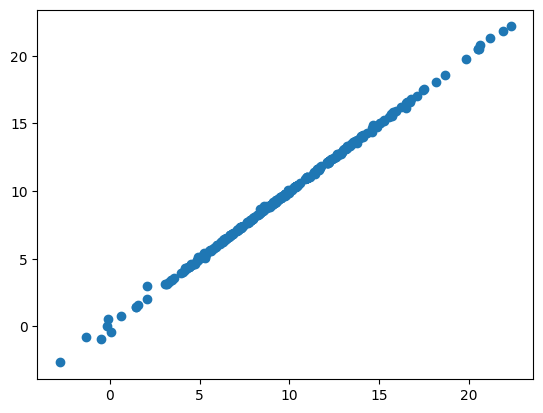

In [43]:
import matplotlib.pyplot as plt
plt.scatter(res['main_feels_like'], res['pred'])

I plotted feature importances to check for leaks, and true temperature had such a high importance, that I had to switch to log plot. As mentioned before, I tried training the model on data without true temperature, and the error went up to 0.77

Here, all the features below top 5 add very little to the model. But the model itself is not computationally expensive or heavy, so I saw no need to throw them away

C:\Users\amost\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\plotting.py:152: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xlim)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

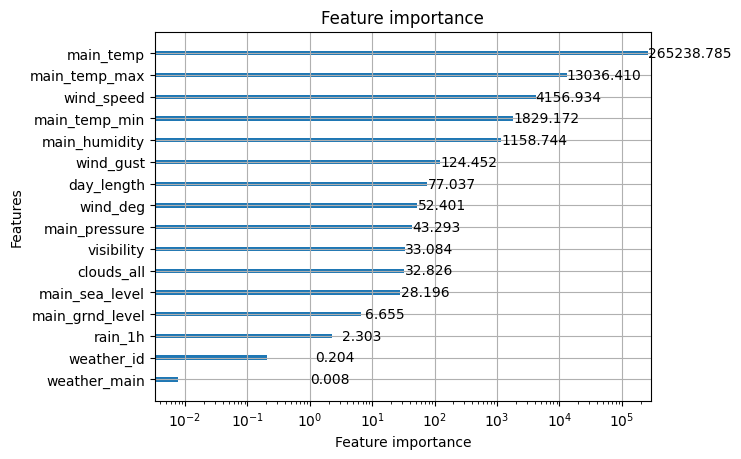

In [44]:
lgb.plot_importance(model, importance_type='gain', log=True)

### Saving the model

In [45]:
model.params

{'objective': 'regression',
 'metric': 'rmse',
 'bagging_freq': 1,
 'feature_pre_filter': False,
 'verbosity': -1,
 'max_depth': 12,
 'learning_rate': 0.033553230741534275,
 'num_leaves': 82,
 'subsample': 0.41600598479701745,
 'colsample_bytree': 0.985612414643452,
 'min_data_in_leaf': 2,
 'num_iterations': 1000,
 'categorical_column': [1, 2, 3]}

In [46]:
model.save_model('lgbm.txt')

Here, I tried to understand why adding date and time features didn't help with accuracy. It's quite obvious that there's no visible correlation between the day of year or hour of day and the difference between real and felt temperature. So if we split by real temperature, adding hour and day features doesn't help

In [48]:
df['day'] = df['dt'].dt.dayofyear
df['hour'] = df['dt'].dt.hour

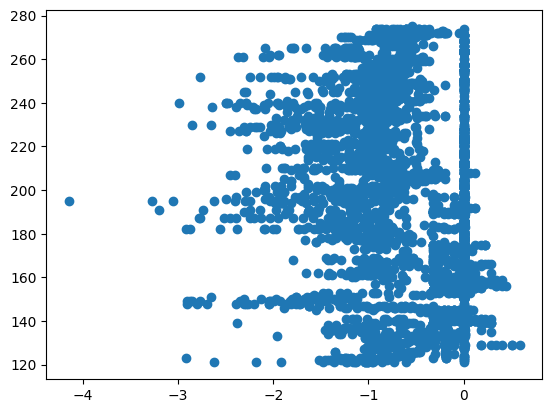

In [49]:
plt.scatter(df['main_feels_like'] - df['main_temp'], df['day'])

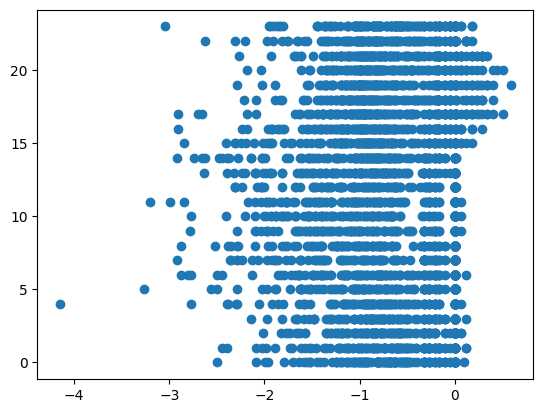

In [50]:
plt.scatter(df['main_feels_like'] - df['main_temp'], df['hour'])

### Trying linear regression

I also tried linear regression as an alternative, but predictebly, its results are much worse

In [27]:
X.drop(columns=['weather_id', 'weather_main', 'weather_description'], inplace=True)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

In [29]:
model = LinearRegression()

In [30]:
model.fit(X_train, y_train)

LinearRegression()

In [32]:
predictions = model.predict(X_val)

In [36]:
res = pd.DataFrame(y_val)

In [37]:
mean_squared_error(y_val, predictions)

0.22846066370190246